In [256]:
#base_shape_ablation_base_shape_32
import torch
import os
import numpy as np
import re
import pandas as pd
import seaborn as sns
import json
import matplotlib.pyplot as plt
def checkpoint_epoch(folder, epoch=49):
    files = os.listdir(folder)
    f = [f for f in files if "batches_{}_.pth".format(epoch) in f]
    if len(f) > 0:
        return f[0]
    return -1
def add_metadata(fname, d):
    match = re.search('width_mult_\d+', fname)
    if match:
        width_mult = match.group(0)[len("width_mult_"):]
        d["width_mult"] = int(width_mult)
    match = re.search('-lr_\d+.\d+', fname)
    if match:
        value = match.group(0)[len("-lr_"):]
        d["lr"] = float(value)
    match = re.search('-depth_mult_\d+', fname)
    if match:
        value = match.group(0)[len("-depth_mult_"):]
        d["depth_mult"] = int(value)
    match = re.search('-parametr_mup_depth', fname)
    if match:
        d["mup_depth"] = True
    else:
        d["mup_depth"] = False
    match = re.search('skip_scaling_\d+(\.\d+)?', fname)
    if match:
        value = match.group(0)[len("skip_scaling_"):]
        d["skip_scaling"] = float(value)
    else:
        d["skip_scaling"] = 1.0
    match = re.search('res_scaling_\d+(\.\d+)?', fname)
    if match:
        value = match.group(0)[len("res_scaling_"):]
        d["res_scaling"] = float(value)
    else:
        d["res_scaling"] = 1.0
    match = re.search('epoch_\d+', fname)
    if match:
        width_mult = match.group(0)[len("epoch_"):]
        d["epochs"] = int(width_mult)
    match = re.search('beta_\d+(\.\d+)?', fname)
    if match:
        value = match.group(0)[len("beta_"):]
        d["beta"] = float(value)
    else:
        d["beta"] = 1.0
    match = re.search('gamma_zero_\d+(\.\d+)?', fname)
    if match:
        value = match.group(0)[len("gamma_zero_"):]
        d["gamma_zero"] = float(value)
    else:
        d["gamma_zero"] = 1.0
    match = re.search('-norm_ln', fname)
    if match:
        d["norm"] = "ln"
    elif re.search('-norm_bn', fname):
        d["norm"] = "ln"
    elif re.search('-norm_None', fname):
        d["norm"] = None
    else:
        d["norm"] = None
    match = re.search('k_layers_\d+', fname)
    if match:
        value = match.group(0)[len("k_layers_"):]
        d["k_layers"] = int(value)
    else:
        d["k_layers"] = None
    match = re.search('batch_size_\d+', fname)
    if match:
        value = match.group(0)[len("batch_size_"):]
        d["batch_size"] = int(value)
    else:
        d["batch_size"] = None
    return d
def get_data(folder_path, param, epoch=49):
    final_d = []
    for fp in os.listdir(folder_path):
        args_file = json.load(open(os.path.join(folder_path, fp, 'args.json'), 'r'))
        if args_file['parametr'] != param:
            continue
        fpath = os.path.join(folder_path, fp)
        d_file = checkpoint_epoch(fpath, epoch=epoch)
        if d_file != -1:
            fpath = os.path.join(fpath, checkpoint_epoch(fpath, epoch=epoch))
            d = torch.load(fpath, map_location=torch.device('cpu'))
            d = add_metadata(fp, d)
            d["name"] = fp
            d['seed'] = args_file['seed']
            d['output_mult'] = args_file['output_mult']
            d['input_mult'] = args_file['input_mult']
            d['base_shape'] = args_file['base_shape']
            final_d.append(d)
    return final_d
def loss_curves(run_ds, train=True, acc=True):
    ds = []
    for d in run_ds:
        loss_d = pd.DataFrame()
        # try:
        if train:
            loss_d["train_loss"] =  d["metrics"]["train_loss"]
            # loss_d["residual"] = d["metrics"]["residual"]
            # loss_d["top_eig_ggn"] = d["metrics"]["top_eig_ggn"]
            if acc:
                if "train_acc" in d["metrics"].keys():
                    loss_d["train_acc"] =  d["metrics"]["train_acc"]
            if "trace" in d["metrics"].keys() and len(d["metrics"]["trace"]) > 1:
                loss_d["trace"] = d["metrics"]["trace"]
            if "top_eig" in d["metrics"].keys() and len(d["metrics"]["top_eig"]) > 1:
                loss_d["top_eig"] = d["metrics"]["top_eig"]
        else:
            loss_d["test_loss"] =  d["metrics"]["test_loss"]
            loss_d["test_acc"] =  d["metrics"]["test_acc"]
        for i in range(100): #some random high number
            ntk_key = f'ntk_eig_{i}'
            if ntk_key in d['metrics'].keys():
                loss_d[ntk_key] = d["metrics"][ntk_key]
            else:
                break
        loss_d["lr"] = d["lr"]
        loss_d["seed"] = d["seed"]
        loss_d["width_mult"] = d["width_mult"]
        loss_d["Width"] = d["width_mult"] * 16
        loss_d["depth_mult"] = d["depth_mult"]
        loss_d["Depth"] = d["depth_mult"] * 3
        loss_d["step"] = loss_d.index
        loss_d["beta"] = d["beta"]
        loss_d["base_shape"] = d["base_shape"]
        loss_d["gamma_zero"] = d["gamma_zero"]
        loss_d["k_layers"] = d["k_layers"]
        loss_d["batch_size"] = d["batch_size"]
        loss_d["output_mult"] = d["output_mult"]
        loss_d["input_mult"] = d["input_mult"]
        ds.append(loss_d)
        # except KeyError:
            # continue
    return pd.concat(ds, axis=0)
def get_metrics_df(run_ds, metric):
    ds = []
    for d in run_ds:
        try:
            d[metric] = d['metrics'][metric][-1]
            d = {k: d[k] for k in (metric, 'input_mult', 'lr', 'output_mult', 'base_shape', 'width_mult', 'depth_mult', 'mup_depth', 'norm', 'gamma_zero', 'beta', 'k_layers', 'batch_size', 'seed')}
            ds.append(d)
        except KeyError as e:
            print(e)
            continue
    return pd.DataFrame(ds)

In [257]:
sns.set_palette(sns.color_palette("viridis", n_colors=5))
sns.set_theme(style="whitegrid", font_scale=2.0, palette=sns.color_palette("viridis", n_colors=5))
n_epochs = 49
folder_path = "/home/ameterez/work/icml2024/rebuttal/base_shape_ablation_base_shape_32_with_small_output_multiplier_input_smaller_net_relu2"
metric = "train_loss"
parameterization = 'mup'
run_ds = get_data(folder_path, param=parameterization, epoch=n_epochs)
df = loss_curves(run_ds, acc=False).reset_index()
# df = df[df['Width'] <= 64]
df["Epoch"] = df["step"] / max(df["step"]) * (n_epochs+1)


lrs = sorted(df.lr.unique())
batchsizes = sorted(df.batch_size.unique())
base_shapes = sorted(df.base_shape.unique())
output_multipliers = sorted(df.output_mult.unique())
input_multipliers = sorted(df.input_mult.unique())
print(batchsizes)
print(lrs)
print(output_multipliers)
print(input_multipliers)

[256]
[0.001, 0.001624, 0.002637, 0.004281, 0.006952, 0.011288, 0.01833, 0.029764, 0.048329, 0.078476, 0.127427, 0.206914, 0.335982, 0.545559, 0.885867, 1.43845, 2.335721, 3.79269, 6.158482, 10.0]
[1024.0, 10000.0]
[1.0]


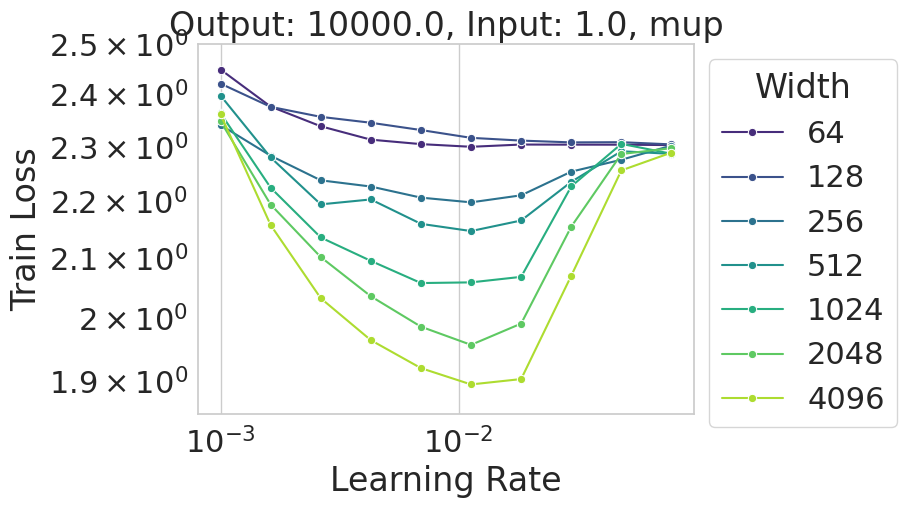

In [269]:
base = base_shapes[0]
output_multiplier = output_multipliers[1]
input_multiplier = input_multipliers[0]
df2 = df[df['base_shape'] == base]
df2 = df2[df2['output_mult'] == output_multiplier]
df2 = df2[df2['input_mult'] == input_multiplier]
df2 = df2[df2['Epoch'] == df2['Epoch'].max()]
# df2 = df2[df2['Width'].isin([64, 2048])]
# df2 = df2[df2['lr'] >= 0.1]
df2 = df2[df2['lr'] <= 0.1]
# df2 = df2[df2['Epoch'] == 20]

fig, ax = plt.subplots(ncols=1, nrows=1)
sns.lineplot(df2, x='lr', y='train_loss', hue='Width', ax=ax, marker='o', palette=sns.color_palette("viridis", n_colors=7))
sns.move_legend(ax, loc='upper left', bbox_to_anchor=(1, 1))
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel("Train Loss")
ax.set_xlabel("Learning Rate")

if parameterization == 'sp':
    parameterization_ = 'ntp'
else:
    parameterization_ = parameterization
ax.set_ylim(bottom=1.85, top=2.5)
# ax.set_title(f"Base width: {base}, {parameterization_}")
ax.set_title(f"Output: {output_multiplier}, Input: {input_multiplier}, {parameterization_}")
# fig.savefig(f"{parameterization_}_base_width_{base}_transfer.pdf", bbox_inches='tight')
fig.show()

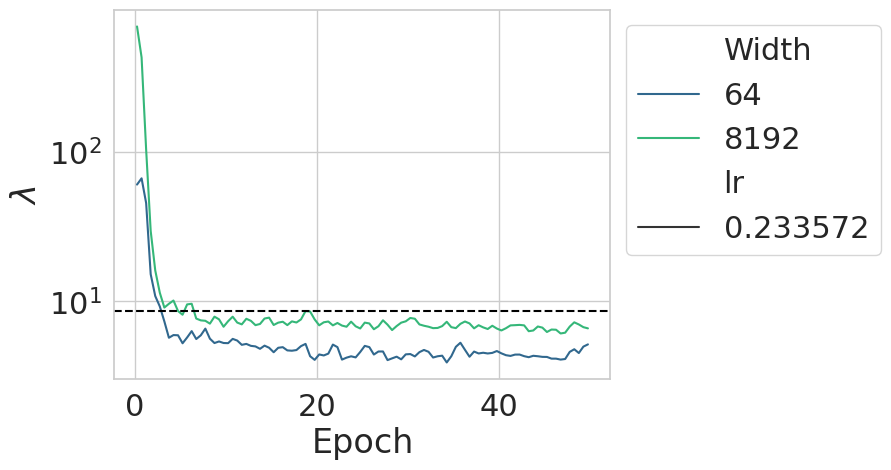

In [255]:
# learningrates = [lrs[7], lrs[12]]
learningrates = [lrs[2]]
df2 = df[df['base_shape'] == base]
df2 = df2[df2['output_mult'] == output_multiplier]
df2 = df2[df2['input_mult'] == input_multiplier]

df2 = df2[df2['Width'].isin([64, 8192])]

df2 = df2.groupby(["Width", "lr", "seed"], as_index=False).rolling(2).mean()
df2 = df2[~df2['top_eig'].isna()]
df2 = df2[df2['lr'].isin(learningrates)]

if parameterization == 'mup':
    df2['top_eig'] *= df['Width'] / base

fig, ax = plt.subplots(ncols=1, nrows=1)
sns.lineplot(df2, x='Epoch', y='top_eig', hue='Width', style='lr', ax=ax, palette=sns.color_palette("viridis", n_colors=2))
sns.move_legend(ax, loc='upper left', bbox_to_anchor=(1, 1))
ax.set_yscale('log')
# ax.set_xscale('log')
ax.set_ylabel(r'$\lambda$')
# ax.set_xlabel("Step")
for lrr in learningrates:
    ax.axhline(y=2/lrr, color='black', linestyle='--')
# ax.set_title(f"Base width: {base}, {parameterization_}")
# ax.set_title(f"Multiplier: {multiplier}, {parameterization_}")
# fig.savefig(f"{parameterization_}_base_width_{base}_sharpness.pdf", bbox_inches='tight')
# fig.show()

In [ ]:
df2 = df[df['lr'].isin([lrs[6], lrs[9]])]
df2['ntk_eig_0'] *= (df2['width_mult']*16)
df2["lr"] = df2["lr"].round(2)
fig, ax = plt.subplots(ncols=1, nrows=1)
sns.lineplot(df2, x='step', y='ntk_eig_0', hue='Width', style='lr', ax=ax, palette=sns.color_palette("viridis", n_colors=5))
sns.move_legend(ax, loc='upper left', bbox_to_anchor=(1, 1))
ax.set_yscale('log')
ax.set_xlabel("Epoch")
ax.set_ylabel(r'$\lambda_{max}(\Theta)$')
fig.savefig('mup_ntk_lambda_max.pdf', bbox_inches='tight')
# fig.show()

In [ ]:
df2 = df[df['lr'].isin([lrs[6], lrs[9]])]
df2['ntk_eig_2'] *= (df2['width_mult']*16)
df2["lr"] = df2["lr"].round(2)
fig, ax = plt.subplots(ncols=1, nrows=1)
sns.lineplot(df2, x='Epoch', y='ntk_eig_2', hue='Width', style='lr', ax=ax, palette=sns.color_palette("viridis", n_colors=5))
sns.move_legend(ax, loc='upper left', bbox_to_anchor=(1, 1))
ax.set_yscale('log')
ax.set_ylabel(r'$\lambda_2(\Theta)$')
# fig.savefig('mup_no_residuals_sharpness.pdf', bbox_inches='tight')
# fig.show()

In [ ]:
df2 = df[df['lr'].isin([lrs[3], lrs[9]])]
df2['ntk_eig_1'] *= (df2['width_mult']*16)

fig, ax = plt.subplots(ncols=1, nrows=1)
sns.lineplot(df2, x='step', y='ntk_eig_2', hue='Width', style='lr', ax=ax, palette=sns.color_palette("viridis", n_colors=5))
sns.move_legend(ax, loc='upper left', bbox_to_anchor=(1, 1))
ax.set_yscale('log')
ax.set_ylabel(r'$\lambda_1$')
ax.set_xlabel("Step")
# fig.savefig('mup_no_residuals_sharpness.pdf', bbox_inches='tight')
# fig.show()

In [ ]:
df2 = df[df['lr'].isin([lrs[3], lrs[9]])]
df2['ntk_eig_0'] *= (df2['width_mult']*16)

fig, ax = plt.subplots(ncols=1, nrows=1)
sns.lineplot(df2, x='step', y='ntk_eig_0', hue='Width', style='lr', ax=ax, palette=sns.color_palette("viridis", n_colors=5))
sns.move_legend(ax, loc='upper left', bbox_to_anchor=(1, 1))
ax.set_yscale('log')
ax.set_ylabel(r'$\lambda_0$')
ax.set_xlabel("Step")
# fig.savefig('mup_no_residuals_sharpness.pdf', bbox_inches='tight')
# fig.show()

In [ ]:
df2 = df[df['lr'].isin([lrs[3], lrs[9]])]
df2['ntk_eig_0'] *= (df2['width_mult']*16)

fig, ax = plt.subplots(ncols=1, nrows=1)
sns.lineplot(df2, x='step', y='ntk_eig_0', hue='Width', style='lr', ax=ax, palette=sns.color_palette("viridis", n_colors=5))
sns.move_legend(ax, loc='upper left', bbox_to_anchor=(1, 1))
ax.set_yscale('log')
ax.set_ylabel(r'$\lambda_0$')
ax.set_xlabel("Step")
# fig.savefig('mup_no_residuals_sharpness.pdf', bbox_inches='tight')
# fig.show()

In [ ]:
y = df[(df['Width'] == 256) & (df['lr'] == lrs[3]) & (df['seed'] == 40)].train_loss.values

In [ ]:
plt.plot(y)

In [ ]:

def hl_envelopes_idx(s, dmin=1, dmax=1, split=False):
    """
    Input :
    s: 1d-array, data signal from which to extract high and low envelopes
    dmin, dmax: int, optional, size of chunks, use this if the size of the input signal is too big
    split: bool, optional, if True, split the signal in half along its mean, might help to generate the envelope in some cases
    Output :
    lmin,lmax : high/low envelope idx of input signal s
    """

    # locals min      
    lmin = (np.diff(np.sign(np.diff(s))) > 0).nonzero()[0] + 1 
    # locals max
    lmax = (np.diff(np.sign(np.diff(s))) < 0).nonzero()[0] + 1 
    
    if split:
        # s_mid is zero if s centered around x-axis or more generally mean of signal
        s_mid = np.mean(s) 
        # pre-sorting of locals min based on relative position with respect to s_mid 
        lmin = lmin[s[lmin]<s_mid]
        # pre-sorting of local max based on relative position with respect to s_mid 
        lmax = lmax[s[lmax]>s_mid]

    # global min of dmin-chunks of locals min 
    lmin = lmin[[i+np.argmin(s[lmin[i:i+dmin]]) for i in range(0,len(lmin),dmin)]]
    # global max of dmax-chunks of locals max 
    lmax = lmax[[i+np.argmax(s[lmax[i:i+dmax]]) for i in range(0,len(lmax),dmax)]]
    
    return lmin,lmax

In [ ]:
lmin, lmax = hl_envelopes_idx(y)

In [ ]:
plt.plot(y[lmin])